In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

DEBUG:matplotlib:matplotlib data path: /Users/oliviercorradi/github/polynomial/.venv/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/oliviercorradi/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/oliviercorradi/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/oliviercorradi/.matplotlib/fontlist-v330.json


In [2]:
from mainapp.views.dashboard import query_measurements_without_gaps

In [10]:
from asgiref.sync import sync_to_async
from mainapp.tasks.metric_analyse import LOOKBACK_DAYS

@sync_to_async
def query(metric_id):
    end_date = date.today()
    start_date = end_date - timedelta(days=LOOKBACK_DAYS)
    results = query_measurements_without_gaps(start_date, end_date, metric_id)
    df = pd.DataFrame([{'date': dt, 'value': value} for dt, value in results]).set_index('date')
    df.index = pd.to_datetime(df.index)
    return df

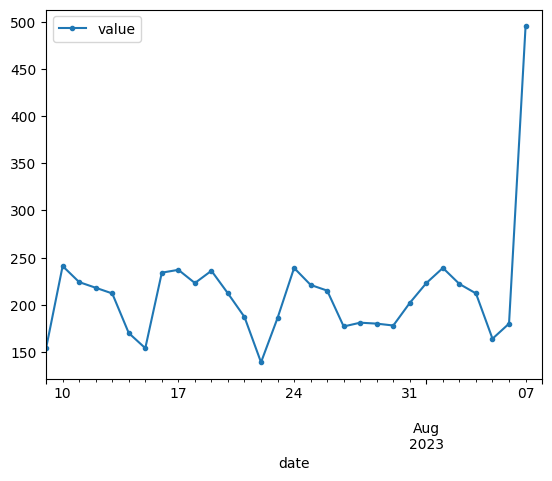

In [6]:
metric_id = 5
df = await query(metric_id)
df.plot(style='.-');

DEBUG:mainapp.tasks.metric_analyse:Detected [datetime.date(2023, 8, 7)] outliers for metric_id=5


            value  trend  is_spike
date                              
2023-07-09  154.0    NaN     False
2023-07-10  241.0    NaN     False
2023-07-11  224.0    NaN     False
2023-07-12  218.0    NaN     False
2023-07-13  212.0  209.8     False
2023-07-14  170.0  213.0     False
2023-07-15  154.0  195.6     False
2023-07-16  234.0  197.6     False
2023-07-17  237.0  201.4     False
2023-07-18  223.0  203.6     False
2023-07-19  236.0  216.8     False
2023-07-20  212.0  228.4     False
2023-07-21  187.0  219.0     False
2023-07-22  139.0  199.4     False
2023-07-23  186.0  192.0     False
2023-07-24  239.0  192.6     False
2023-07-25  221.0  194.4     False
2023-07-26  215.0  200.0     False
2023-07-27  177.0  207.6     False
2023-07-28  181.0  206.6     False
2023-07-29  180.0  194.8     False
2023-07-30  178.0  186.2     False
2023-07-31  202.0  183.6     False
2023-08-01  223.0  192.8     False
2023-08-02  239.0  204.4     False
2023-08-03  222.0  212.8     False
2023-08-04  212.0  2

True

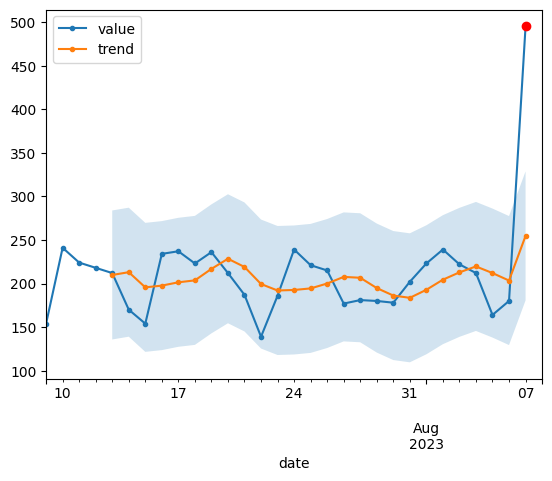

In [17]:
from mainapp.tasks.metric_analyse import STD_MULTIPLIER, detected_spike

df['trend'] = df['value'].rolling(5).mean()
std = df['trend'].std()
ax = df[['value', 'trend']].plot(style='.-');
# add noise level
d = df.index.to_pydatetime()
plt.fill_between(d, df['trend'] - std * STD_MULTIPLIER, df['trend'] + std * STD_MULTIPLIER, alpha=0.2)
# detect points
df['is_spike'] = (~df['value'].isna()) & ((df['trend'] - df['value']).abs() > std * STD_MULTIPLIER)
# mark
df['value'].where(df['is_spike']).plot(style='o', color='red')

# Check current implementation
await sync_to_async(detected_spike)(metric_id)

In [7]:
# Verify it is the last point
import decimal
from mainapp.models import Measurement

@sync_to_async
def query_measurement():
    return Measurement.objects.exclude(value=float('nan')).filter(metric=metric_id).order_by('date').last()

await query_measurement()

<Measurement: 2023-08-07 = 495.0>